In [ ]:
!pip install NEURON

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 37.5 MB/s eta 0:00:00


In [ ]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks as fp
h.load_file('stdrun.hoc')



class Myelinated_Axon():
    #This class is a wrapper for NEURON's Hodgkin Huxely multicompartment myelinated axon.
    #It does not need to be edited
    #Create a new Myelinated axon using:
    #    x = Myelinated_Axon()

    #see https://www.w3schools.com/python/python_classes.asp
    #for more information in classes in python

    def __init__(self,myelin_capacitance=0.005):
        #creates nodes and myelinates internodes
        self.nodes = []
        self.myelins = []

        for i in range(10):
            self.nodes.append(h.Section(name = f"Node_{i}"))
        for i in range(9):
            self.myelins.append(h.Section(name = f"Myelins_{i}"))

        #connect nodes and myelin into one long axone
        for i in range(9):
            self.myelins[i].connect(self.nodes[i])
            self.nodes[i+1].connect(self.myelins[i])

        #set properties for nodes and myelin
        for n in self.nodes:
            n.L=3.183
            n.diam =10
            n.Ra = 100
            n.insert("hh")
            n.gnabar_hh=1.2
            n.gkbar_hh =0.36
            n.gl_hh = .003
            n.ena = 50
            n.ek = -77
            n.cm = 1.0

        for n in self.myelins:
            n.L=2000
            n.diam =10
            n.Ra = 100
            n.insert("pas")
            n.e_pas = -65
            n.g_pas = 1.5e-6
            n.cm = myelin_capacitance

        #Record default variables
        self.t_vec = h.Vector()        # Time stamp vector
        self.t_vec.record(h._ref_t)

        #allow multiple stimulations to be used (might not be necessary for lab)
        self.stimulators = []

        self.voltage_vectors = {}
        self.current_vectors = {"Sodium":{},"Potassium":{}}


    def stimulate(self,node_index,time,duration=1,amplitude=10000):
        stim = h.IClamp(self.nodes[node_index](0.5))
        stim.delay = time
        stim.dur = duration
        stim.amp = amplitude
        self.stimulators.append(stim)

    def record_voltage(self,node_index):
        #Record membrane potential at a node on the axon
        v_vec = h.Vector()
        v_vec.record(self.nodes[node_index](0.5)._ref_v)
        self.voltage_vectors[node_index]=v_vec

    def record_current(self,current,node_index):
        currents = {"Sodium":"_ref_ina",
                   "Potassium":"_ref_ik"}
        if not current in currents:
            print("Current should be a string, either \"Sodium\" or \"Potassium\" ")

        v_vec = h.Vector()
        v_vec.record(getattr(self.nodes[node_index](0.5),currents[current]))

        self.current_vectors[current][node_index] = v_vec

    def get_voltage(self,node_index):
        #Return voltage at a prerecorded location
        return np.array(self.voltage_vectors[node_index])

    def get_current(self,current,node_index):
        #Return current at a prerecorded location
        return np.array(self.current_vectors[current][node_index])

    def get_time(self):
        return np.array(self.t_vec)

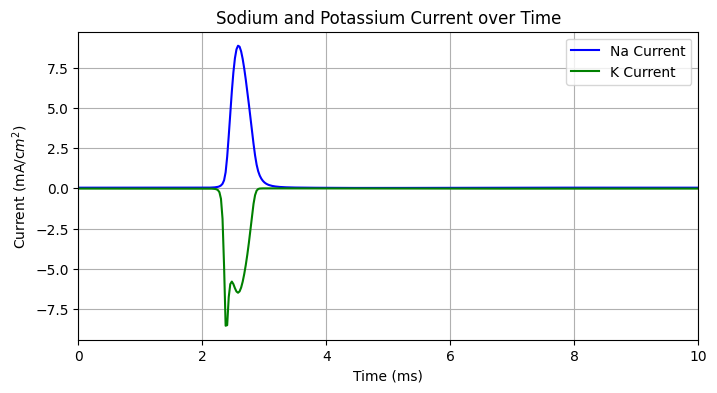

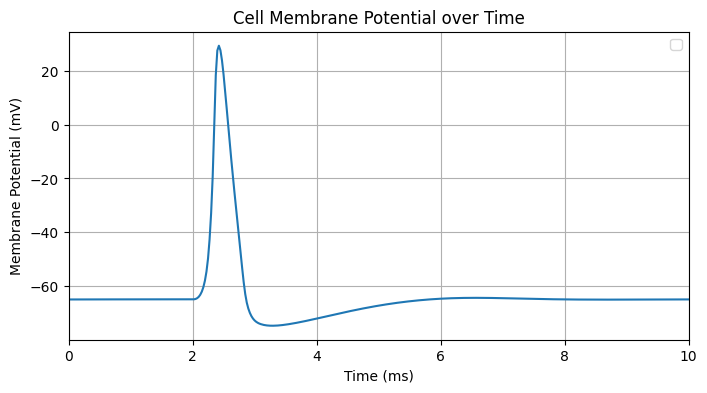

In [ ]:
# Exercise 1
#Simulation set up
h.tstop = 10 #simulation duration
h.celsius = 22 #temperature (in celsius)
h.finitialize(-65) #initialise simulation

#Create a neuron and set the parameters
M = Myelinated_Axon(myelin_capacitance=0.005)
M.record_voltage(0) #record voltage from node 0
M.record_voltage(4) #record voltage from node 4
M.record_current("Potassium",4) #record potassium current at node 4
M.record_current("Sodium",4) #record sodium current at node 4
M.stimulate(node_index=0,time=2,duration=1,amplitude=10)

#Run the simulation
h.run()

#Get variables to be plotted
t = M.get_time()
v = M.get_voltage(0) #get voltage from node 0
v2 = M.get_voltage(4) #get voltage from node 4
Na = M.get_current("Potassium",4) #get sodium current from node 4
K = M.get_current("Sodium",4) #get potassium current from node 4


del M #Very important to delete the axon when you are finished

#Plot variables
plt.figure(figsize=(8,4))
plt.title('Sodium and Potassium Current over Time')
plt.plot(t, Na, color="blue", label = "Na Current")
plt.plot(t, K, color="green", label = "K Current")
plt.xlabel('Time (ms)')
plt.ylabel('Current (mA/c$m^2$)')
plt.xlim(0,h.tstop)
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(t, v2)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Cell Membrane Potential over Time')
plt.xlim(0,h.tstop)
plt.legend()
plt.grid()
plt.show()


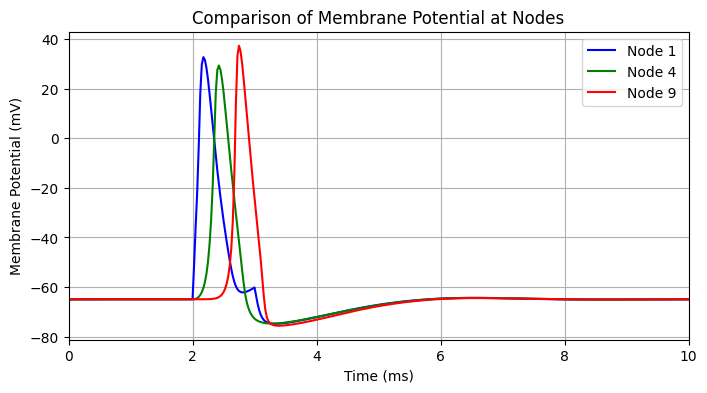

In [ ]:
# Execrise 2
#Simulation set up
h.tstop = 10 #simulation duration
h.celsius = 22 #temperature (in celsius)
h.finitialize(-65) #initialise simulation

#Create a neuron and set the parameters
M = Myelinated_Axon(myelin_capacitance=0.005)
M.record_voltage(1) #record voltage from node 0
M.record_voltage(4) #record voltage from node 4
M.record_voltage(9) #record voltage from node 9
M.stimulate(node_index=0,time=2,duration=1,amplitude=10)

#Run the simulation
h.run()

#Get variables to be plotted
t = M.get_time()
v1 = M.get_voltage(1) #get voltage from node 0
v4 = M.get_voltage(4) #get voltage from node 4
v9 = M.get_voltage(9) #get voltage from node 9


del M #Very important to delete the axon when you are finished

#Plot variables
plt.figure(figsize=(8,4))
plt.plot(t, v1, color="blue", label = "Node 1")
plt.plot(t, v4, color="green", label = "Node 4")
plt.plot(t, v9, color="red", label = "Node 9")
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.xlim(0,h.tstop)
plt.legend()
plt.title('Comparison of Membrane Potential at Nodes')
plt.grid()
plt.show()


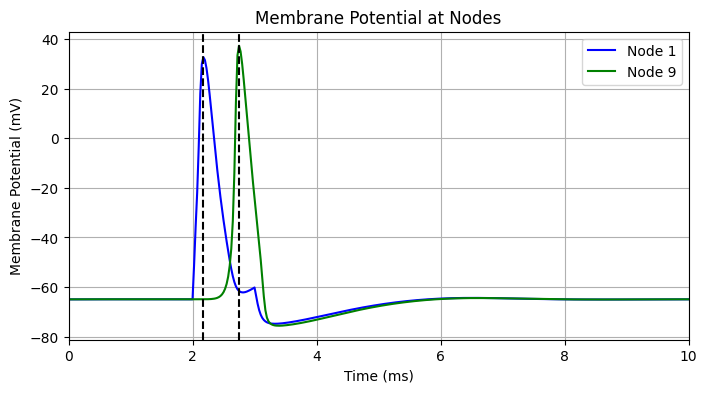

[27.86483652] m/s


In [ ]:
#Exercise 3 - a
#Simulation set up
h.tstop = 10 #simulation duration
h.celsius = 22 #temperature (in celsius)
h.finitialize(-65) #initialise simulation

#Create a neuron and set the parameters
M = Myelinated_Axon(myelin_capacitance=0.005)
M.record_voltage(1) #record voltage from node 1
M.record_voltage(9) #record voltage from node 9
M.stimulate(node_index=0,time=2,duration=1,amplitude=10)

#Run the simulation
h.run()

#Get variables to be plotted
t = M.get_time()
v1 = get_M.voltage(1) #get voltage from node 1
v9 = M.get_voltage(9) #get voltage from node 9


del M #Very important to delete the axon when you are finished

#Plot variables
plt.figure(figsize=(8,4))
plt.plot(t, v1, color="blue", label = "Node 1")
plt.plot(t, v9, color="green", label = "Node 9")
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Membrane Potential at Nodes')
plt.xlim(0,h.tstop)
plt.legend()
plt.grid()
t1, _ = fp(v1, distance = 1000)
t9, _ = fp(v9, distance = 1000)

T1 = t[t1]
T9 = t[t9]
plt.axvline(T1, linestyle = '--', color = 'k')
plt.axvline(T9, linestyle = '--', color = 'k')
plt.show()
dt = T9-T1
Lnode = 2000
Linternode = 3.183
dx = 8*Lnode +7*Linternode
condvel = (dx/10**6)/(dt/10**3)



print(condvel, 'm/s')

Text(0, 0.5, 'Conductance Velocity (m/s)')

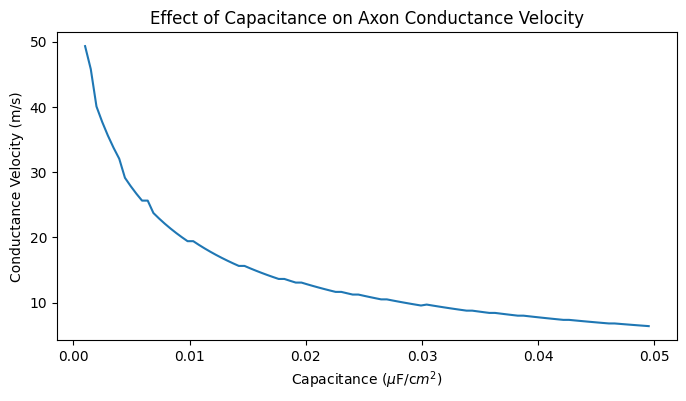

In [ ]:
#Exercise 3 - b
Cstart = 0.001
Cend = 0.05
Csteps = 100
Cs = np.arange(Cstart, Cend, (Cend - Cstart)/Csteps)

Lnode = 2000
Linternode = 3.183
dx = 8*Lnode +7*Linternode

condvelsC = []
for Cm in (Cs):
  #Simulation set up
  h.tstop = 10 #simulation duration
  h.celsius = 22 #temperature (in celsius)
  h.finitialize(-65) #initialise simulation

  #Create a neuron and set the parameters
  M = Myelinated_Axon(myelin_capacitance=Cm)
  M.record_voltage(1) #record voltage from node 1
  M.record_voltage(9) #record voltage from node 9
  M.stimulate(node_index=0,time=2,duration=1,amplitude=10)

  #Run the simulation
  h.run()

  #Get variables to be plotted
  t = M.get_time()
  v1 = M.get_voltage(1) #get voltage from node 1
  v9 = M.get_voltage(9) #get voltage from node 9


  del M #Very important to delete the axon when you are finished

  t1, _ = fp(v1, distance = 1000)
  t9, _ = fp(v9, distance = 1000)

  T1 = t[t1]
  T9 = t[t9]

  dt = T9-T1

  condvelsC = np.append(condvelsC, ((dx/10**6)/(dt/10**3)))

#Plot variables
plt.figure(figsize=(8,4))
plt.plot(Cs, condvelsC)
plt.title('Effect of Capacitance on Axon Conductance Velocity')
plt.xlabel('Capacitance ($\u03BC$F/c$m^2$)')
plt.ylabel('Conductance Velocity (m/s)')



In [ ]:
#Exercise 4
Tstart = 6.3
Tend = 22
Tsteps = 2

Ts = [Tstart, Tend]

condvelsT = []
for T in (Ts):
  #Simulation set up
  h.tstop = 10 #simulation duration
  h.celsius = T #temperature (in celsius)
  h.finitialize(-65) #initialise simulation

  #Create a neuron and set the parameters
  M = Myelinated_Axon(myelin_capacitance = 0.005)
  M.record_voltage(1) #record voltage from node 1
  M.record_voltage(9) #record voltage from node 9
  M.stimulate(node_index=0,time=2,duration=1,amplitude=10)

  #Run the simulation
  h.run()

  #Get variables to be plotted
  t = M.get_time()
  v1 = M.get_voltage(1) #get voltage from node 1
  v9 = M.get_voltage(9) #get voltage from node 9


  del M #Very important to delete the axon when you are finished

  t1, _ = fp(v1, distance = 1000)
  t9, _ = fp(v9, distance = 1000)

  T1 = t[t1]
  T9 = t[t9]

  dt = T9-T1
  Lnode = 2000
  Linternode = 3.183
  dx = 8*Lnode +7*Linternode
  condvelsT = np.append(condvelsT, ((dx/10**6)/(dt/10**3)))

print('%.3f m/s Slower' %(condvelsT[1] - condvelsT[0]))


11.432 m/s Slower


Text(0, 0.5, 'Conductance Velocity (m/s)')

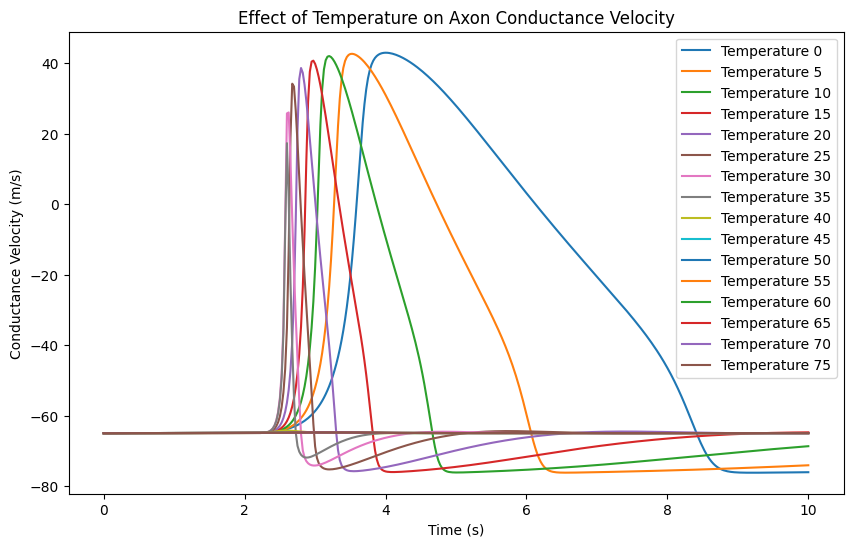

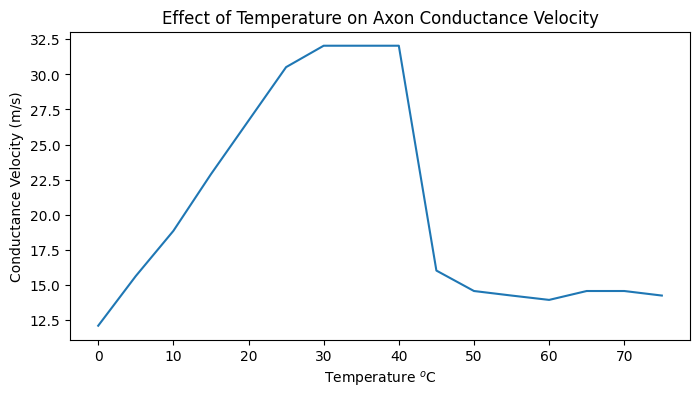

In [ ]:
#Exercise 4
Tstart = 0
Tend = 80
Tstepsize = 5

Ts = np.arange(Tstart, Tend, (Tstepsize))
plt.figure(figsize=(10,6))

condvelsT = []
for T in (Ts):
  #Simulation set up
  h.tstop = 10 #simulation duration
  h.celsius = T #temperature (in celsius)
  h.finitialize(-65) #initialise simulation

  #Create a neuron and set the parameters
  M = Myelinated_Axon(myelin_capacitance = 0.005)
  M.record_voltage(1) #record voltage from node 1
  M.record_voltage(9) #record voltage from node 9
  M.stimulate(node_index=0,time=2,duration=1,amplitude=10)

  #Run the simulation
  h.run()

  #Get variables to be plotted
  t = M.get_time()
  v1 = M.get_voltage(1) #get voltage from node 1
  v9 = M.get_voltage(9) #get voltage from node 9


  del M #Very important to delete the axon when you are finished

  plt.plot(t, v9, label = ('Temperature %s' %T))
  plt.title('Effect of Temperature on Axon Conductance Velocity')
  plt.xlabel('Time (s)')
  plt.ylabel('Conductance Velocity (m/s)')


  t1, _ = fp(v1, distance = 1000)
  t9, _ = fp(v9, distance = 1000)

  T1 = t[t1]
  T9 = t[t9]

  dt = T9-T1
  Lnode = 2000
  Linternode = 3.183
  dx = 8*Lnode +7*Linternode
  condvelsT = np.append(condvelsT, ((dx/10**6)/(dt/10**3)))

plt.legend()
#Plot variables
plt.figure(figsize=(8,4))
plt.plot(Ts, condvelsT)
plt.title('Effect of Temperature on Axon Conductance Velocity')
plt.xlabel('Temperature $^o$C')
plt.ylabel('Conductance Velocity (m/s)')

